# Implementing a sequence to sequence model with attention


## Overview of the task

The attention mechanism in sequence to sequence models addresses the problem of condensing all the input information in one hidden state. Allowing the decoder to access key parts in the input sequence. The weights associated with each hidden state are learned by the attention block.



## *1 - Implementing a sequence to sequence RNN*

Parameters are shared across the steps of the network, learnable parameters are
(Wh, Wi, Wo). This architecture is useful for capturing temporal/sequential relationships that exist in input data


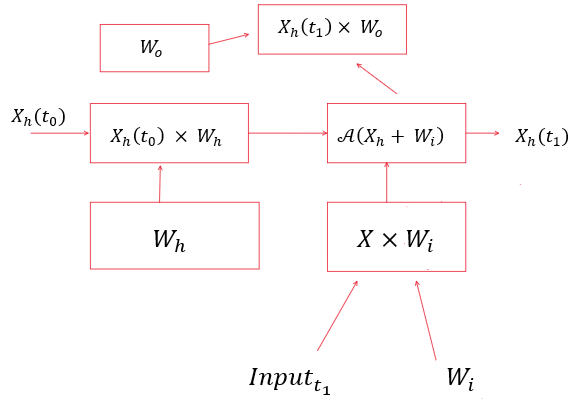

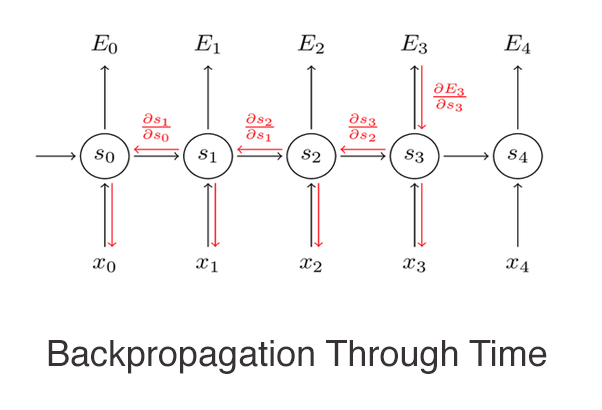


**The loss function of the model**

$$-\sum_{t}logp_m(y^t|x^1,....,x^t)$$


**The space complexity of the operations**

In traditional Rnns the time and space complexity of a forward and backward pass is $$O(τ)$$ and cannot be reduced by parallelization (unless teacher forcing mechanism is used ). Since each step in the computation graph depends on the previous steps. The states computed in the forward pass must be stored until their used in the backward pass.


In [ ]:
from sympy import symbols
x = symbols("x")

### Tanh is used as the activation function in Rnns :  

it allow for easier optimisation compared to a sigmoid activation for example

$1 - \tanh^2{x}$

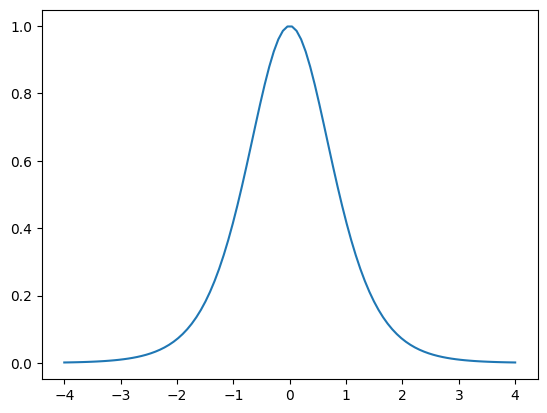

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def tanh(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    dt=1-t**2
    return t,dt
z=np.linspace(-4,4,100)
plt.plot(z, tanh(z)[1])

plt.show()

# RNN net

In [ ]:
import numpy as np

In [ ]:
class data:
  # inspired from : https://gist.github.com/karpathy/**d4dee566867f8291f086**
  def __init__(self, path):

    self.path = path
    data = open(path, 'r').read()
    self.chars = list(set(data))
    self.data_size = len(data)
    self.vocab_size = len(self.chars)
    self.char_to_ix = { ch:i for i,ch in enumerate(self.chars) }
    self.ix_to_char = { i:ch for i,ch in enumerate(self.chars) }

  def ix_to_char(self, i):

    return self.ix_to_char[i]

  def char_to_ix(self, c):

    return self.char_to_ix[c]

In [ ]:
class RNN:

  def __init__(self, hidden_s, vocab_size, seq_length, lr):


    self.hidden_s = hidden_s
    self.seq_length = seq_length
    self.vocab_size = vocab_size
    self.lr = lr
    self.Wh = np.zeros((hidden_s, hidden_s))
    self.Wi = np.zeros(vocab_size, hidden_s) # recommended to initialize the weights in the case of a tanh activation function between -+ 1/sqrt(num incoming connections)
    self.Wo = np.zeros(hidden_s, vocab_size)
    self.bh = np.zeros(hidden_s, 1)
    self.bo = np.zeros(vocab_size, 1)

    def softmax(self, X):

      return np.exp(X) / np.sum(np.exp(X))


  def forward_(self, X):
     # reshape to matrix before calling the method

    hidden = np.zeros((self.hidden_s, 1))
    xij = x @ self.Wi

    xhj = np.tanh(xij + hidden @ self.Wh + self.bh)
    xoj = xhj @ self.Wo + self.bo
    output = xoj

    p = self.softmax(output)

    return output, p

  def forward(self, inputs, hprev):
    xs, hs, os, yh = {}, {}, {}, {}
    hs[-1] = np.copy(hprev)

    for t in range(len(inputs)):

      xs[t] = np.zeros((self.vocab_size, 1))
      xs[t][inputs[t]] = 1
      hs[t] = np.tanh( xs[t] @ self.Wi + hs[t-1] @ self.Wh + self.bh)
      os[t] = hs[t] @ self.Wo + self.bo
      yh[t] = self.softmax(os[t])

      return xs, hs, yh

  def loss(self, ps, targets):

    return sum(-np.log(ps[t][targets[t],0]) for t in range(self.seq_length))


  def backward(self, xs, hs, yh, targets):


    dbh,dbo = np.zeros_like(self.bh), np.zeros_like(self.bo)
    dwh, dwi, dwo = np.zeros_like(self.Wh), np.zeros_like(self.Wi), np.zeros_like(self.Wo)
    dhn = np.zeros_like(hs[0])

    for step in range(len(self.seq_length)-1, -1, -1):
      do = np.copy(yh[step]) # init step : output
      do[targets[step]] = - 1 # softmax grad
      dwo  += np.dot(do, hs[step].T)
      dbo += do
      dh = np.dot(self.Wo.T, do)
      dhr = (1 - hs[step]*hs[step])*dh
      dbh += dhr
      dwi += np.dot(dhr, xs[step].T)
      dwh += np.dot(dhr, xs[step-1].T)
      dhn = np.dot(self.Wh.T, dhr)

    for dparam in [dwh,dwi,dbh,dbo,dwo]:  # clipping gradients to avoid exploding gradient problem when dealing with rnns (happens less frequently than the vanishing gradient problem (gradients of tanh are between 0 and 1))
      np.clip(dparam, -4, 4, out = dparam)

    return dwi,dwh,dwo,dbh,dbo

  def update(self, dwi, dwh, dwo, dbh, dbo):

    for param, dparam in zip([self.Wi, self.Wh, self.Wo], [dwi, dwh, dwo, dbh, dbo]):

      param -= self.lr * dparam

  def predict(self, data , st, n):

    x = np.zeros(self.vocab_size, 1)

    characters = [c for c in st]
    ixs = []
    for i in range(len(characters)):
      ix = data.char_to_ix[characters[i]]
      x[ix] = 1
      ixs.append(ix)

    h = np.zeros((self.hidden_s,1))
    for _ in range(n):

      _ , p = self.forward_(x)
      ix = np.random.choice(range(self.vocab_size), p=p.ravel())
      x = np.zeros((self.vocab_size, 1))
      x[ix] = 1
      ixs.append(ix)

    return " ".join(data.ix_to_char[i] for i in ixs)

In [ ]:
dt = data('/content/input.txt')


hidden_s, vocab_size, seq_length, lr = 100, data.vocab_size, 10, 0.0001

rnn = RNN(hidden_s, vocab_size, seq_length, lr)